# 자동차 연비 예측하기: 회귀
- 회귀: 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적
- 분류: 여러개의 클래스 중, 하나의 클래스를 선택하는 것이 목적

- Data
    - Auto MPG 데이터셋 사용
    - 1970년대 후반, 1980년대 초반의 자동차 연비를 예측하는 모델
    - 위 기간에 출시된 자동차 정보를 모델에 제공
    - 실린더 수, 배기량, 마력, 공차 중량 같은 속성 포함

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Get data

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/Users/hsy/.keras/datasets/auto-mpg.data'

In [13]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Preprocessing

In [14]:
# 데이터 누락 확인
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [15]:
# 데이터 누락된 행 제거
dataset = dataset.dropna()

In [16]:
# 수치형 데이터 범주형으로 변환
origin = dataset.pop('Origin')
# one-hot encoding
dataset['USA'] = (origin == 1) * 1
dataset['Europe'] = (origin == 2) * 1
dataset['Japan'] = (origin == 3) * 1
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


## train, test split

In [17]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Data Exploration

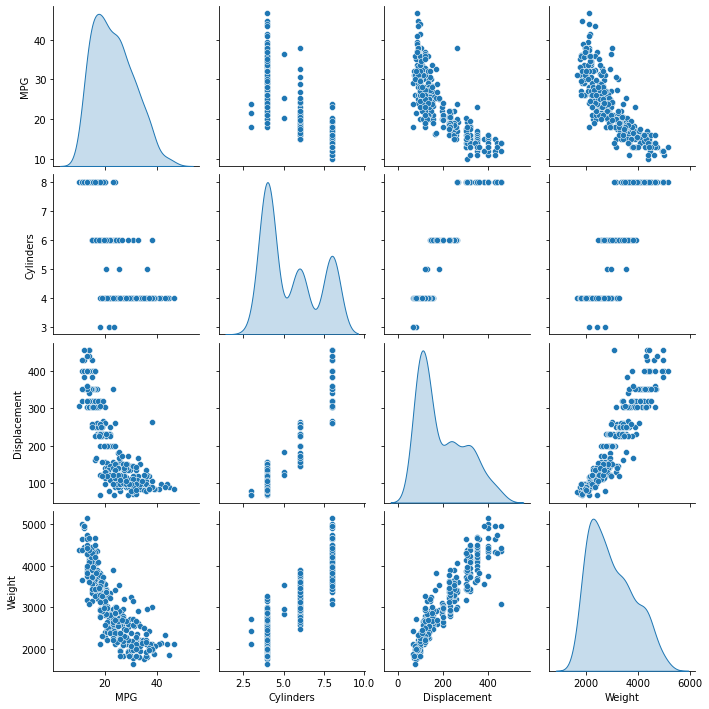

In [20]:
# 산점도 행렬
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [22]:
# 통계 확인
train_stats = train_dataset.describe()
train_stats.pop('MPG')
# 전치행렬
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [23]:
# 레이블 분리
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [24]:
# Scaling (정규화)
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Model

In [26]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

In [28]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [29]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.13652833],
       [ 0.00134167],
       [ 0.0673508 ],
       [-0.14298852],
       [ 0.44012663],
       [ 0.10188674],
       [ 0.5102559 ],
       [ 0.4725666 ],
       [ 0.01416247],
       [ 0.5160395 ]], dtype=float32)

In [30]:
# model train
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

         loss       mae       mse  val_loss   val_mae   val_mse  epoch
995  2.224913  0.988652  2.224913  8.942027  2.322336  8.942026    995
996  2.221598  0.978132  2.221598  9.355718  2.395698  9.355718    996
997  2.155214  0.969617  2.155214  8.977573  2.327103  8.977573    997
998  2.287759  0.993853  2.287759  8.841603  2.305366  8.841603    998
999  2.209703  1.010248  2.209703  9.594246  2.431731  9.594246    999


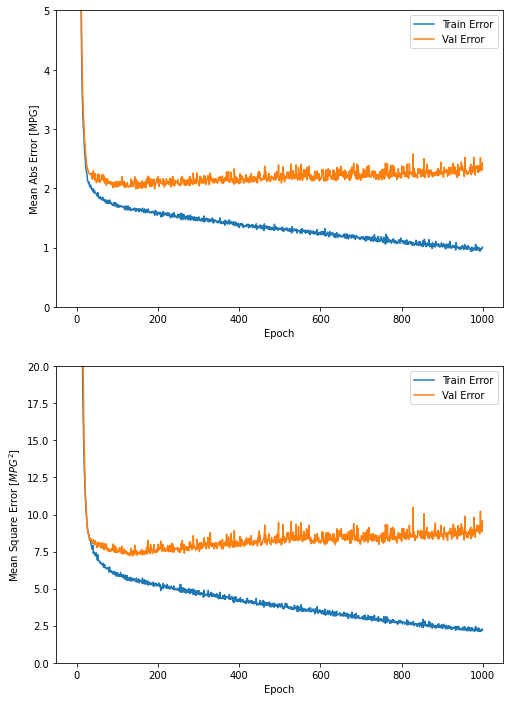

In [32]:
# train process visulization
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())

import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)


....................................................................................................
.

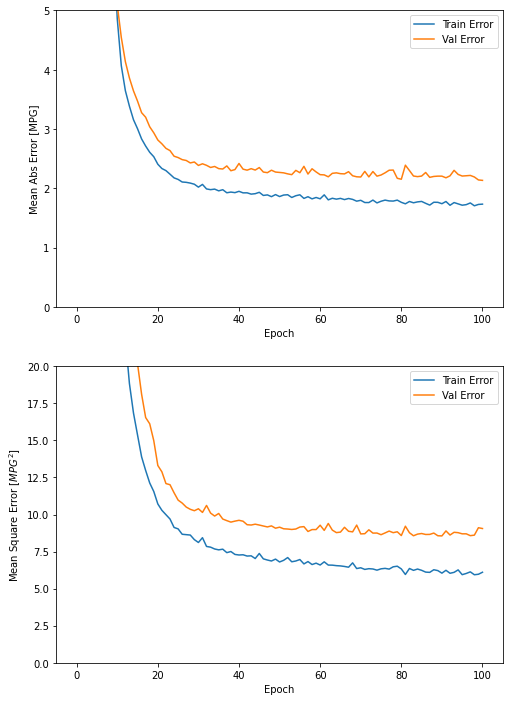

In [33]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다 --> 성능 향상이 없으면 자동으로 훈련이 멈추도록 지정
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [34]:
# Evaluation
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.6939 - mae: 2.0538 - mse: 6.6939
테스트 세트의 평균 절대 오차:  2.05 MPG


## Prediction

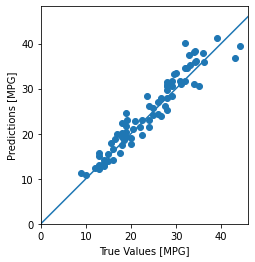

In [35]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

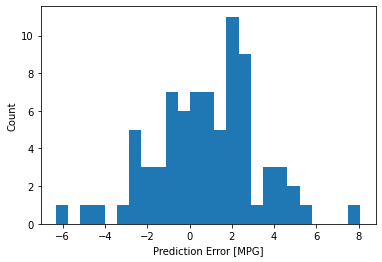

In [36]:
# 오차 분포
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## 결론
- 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수(분류 문제에서 사용하는 손실 함수와 다름)
- 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다름. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)
- 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야함
- 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋음
- 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법